In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
columns = Measurement.__table__.columns
print([column.name for column in columns])

['id', 'station', 'date', 'prcp', 'tobs']


In [10]:
columns = Station.__table__.columns
print([column.name for column in columns])

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


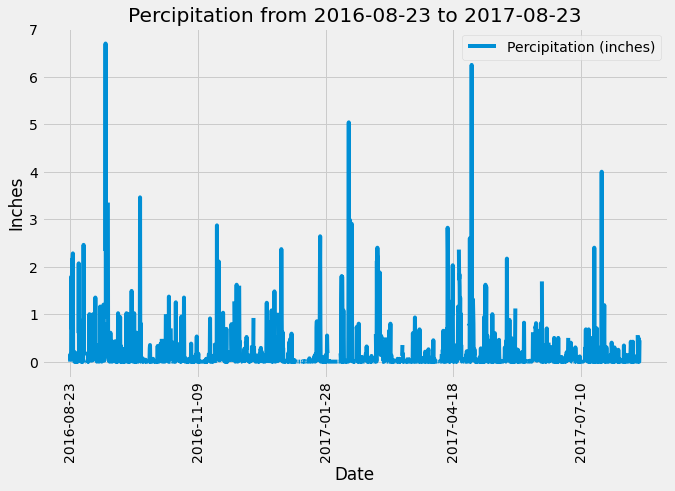

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date() - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(query, columns=['Date', 'Percipitation (inches)']).set_index('Date')

# Sort the dataframe by date
measurement_df = measurement_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(title='Percipitation from 2016-08-23 to 2017-08-23',
                    ylabel= 'Inches',
                    figsize = (10,6),
                    rot=90)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,Percipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.name).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).\
                    all()

for station in active_stations:
    print(f"{station[0]}: {station[1]} rows")
    
most_active_station = active_stations[0][0]

USC00519281: 2772 rows
USC00519397: 2724 rows
USC00513117: 2709 rows
USC00519523: 2669 rows
USC00516128: 2612 rows
USC00514830: 2202 rows
USC00511918: 1979 rows
USC00517948: 1372 rows
USC00518838: 511 rows


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_lowest = session.query(func.min(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).\
                        scalar()
most_active_highest = session.query(func.max(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).\
                        scalar()
most_active_average = session.query(func.avg(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).\
                        scalar()

print(f'station: {most_active_station}, temperature\nlowest: {most_active_lowest}, highest: {most_active_highest}, average: {most_active_average}')

station: USC00519281, temperature
lowest: 54.0, highest: 85.0, average: 71.66378066378067


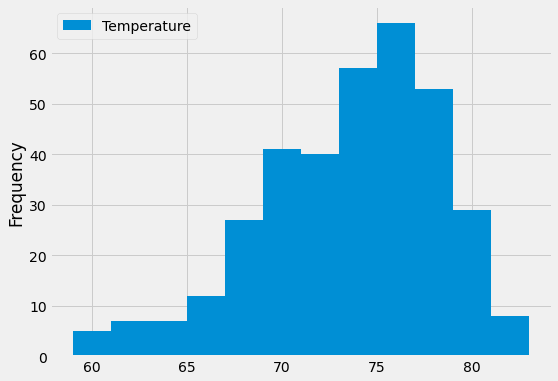

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_query = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= last_year_date).\
                    filter(Measurement.station == most_active_station).\
                    order_by(Measurement.date).all()

most_active_df = pd.DataFrame(most_active_query, columns=['Date', 'Temperature'])
most_active_df.set_index('Date', inplace=True)

most_active_df.plot(kind='hist',
                    figsize=(8,6),
                    xlabel='Temperature',
                    bins=12)
plt.show()

# Close session

In [18]:
# Close Session
session.close()